# Visualising with LavaVu

[LavaVu](https://github.com/OKaluza/LavaVu) is a lightweight, automatable visualisation and analysis viewing utility.


In [1]:
from LavaVu import lavavu

import numpy as np
from quagmire import FlatMesh, TopoMesh
from quagmire import tools as meshtools

import petsc4py
from petsc4py import PETSc

from mpi4py import MPI
comm = MPI.COMM_WORLD

In [2]:
minX, maxX = -5., 5.
minY, maxY = -5., 5.
spacing = 0.033

ptsx, ptsy, bmask = meshtools.poisson_elliptical_mesh(minX, maxX, minY, maxY, spacing, 500)

dm = meshtools.create_DMPlex_from_points(ptsx, ptsy, bmask, refinement_steps=3)
mesh = TopoMesh(dm)

pts, simplices, bmask = mesh.get_local_mesh()

x = pts[:,0]
y = pts[:,1]

# create height field
radius  = np.sqrt((x**2 + y**2))
theta   = np.arctan2(y,x)

height  = np.exp(-0.025*(x**2 + y**2)**2) + \
          0.25 * (0.2*radius)**4  * np.cos(10.0*theta)**2
height  += 0.5 * (1.0-0.2*radius)

mesh.update_height(height)

 - Delaunay triangulation 8.103468s
 - cKDTree 1.811911s
 - Calculate node weights and area 0.153273s
 - Compute edge lengths 7.691539s
 - Construct nearest neighbour array 22.298269s
 - Find boundaries 0.00697899999999s
 - Build smoothing matrix 1.460336s
 - Construct neighbour cloud array 13.792543s
 - Construct rbf weights 5.461782s
 - Sort nodes by field 6.297675s
 - Build downhill matrices 11.932271s


In [3]:
## Create flows

flowpaths = mesh.cumulative_flow(np.ones_like(mesh.height))



In [4]:
mesh.npoints

2870713

**Create a viewer**

In [5]:
lv = lavavu.Viewer(border=False, background="#FFFFFF", resolution=[1000,600], near=-10.0)

**Plot a triangle surface**

Can be vertices only (3 per tri) or vertices (shared) with indices (3 per tri)

In [6]:
# Prepare the triangles

tris  = lv.triangles("surface",      wireframe=False, colourmap="isolum", logScale=False)
tris2 = lv.triangles("flow_surface", wireframe=False, colourmap="isolum", logScale=False)

verts = np.reshape(mesh.tri.points, (-1,2))
verts = np.insert(verts, 2, values=mesh.height, axis=1)

tris.vertices(verts)
tris.indices(mesh.tri.simplices)

verts[:,2] += 0.01

tris2.vertices(verts)
tris2.indices(mesh.tri.simplices)

**Add values, can be used to colour and filter the data**

In [7]:
#Use topography value to colour the surface

tris.values(mesh.height, 'topography')
tris2.values((flowpaths), 'flowpaths')

cb = tris.colourbar(visible=False) # Add a colour bar

cm = tris.colourmap(["#EEFFEE", "#999999", "#444444"] , logscale=False)   # Apply a built in colourmap
cm = tris2.colourmap(["#FFFFFF:0.0", "#0055FF:0.6", "#000033"], logscale=True)   # Apply a built in colourmap

#Filter by min height value
tris["zmin"] = -0.1

**Apply an initial rotation and display an interactive viewer window**

Along with viewer window, controls can be added to adjust properties dynamically

In [8]:
# lv.rotate('x', -60)
lv.window()

tris.control.Checkbox('wireframe',  label="Topography wireframe")
tris2.control.Checkbox('wireframe', label="Flow wireframe")

# tris.control.Range(property='zmin', range=(-1,1), step=0.001)
# lv.control.Range(command='background', range=(0,1), step=0.1, value=1)
# lv.control.Range(property='near', range=[-10,10], step=2.0)
lv.control.Checkbox(property='axis')
lv.control.Command()
lv.control.ObjectList()
lv.control.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Saving camera position, images and state**



In [9]:
lv.camera() #Get current camera as set in viewer

lv.translation(0.0, 0.0, 0.0)
lv.rotation(0.0, 0.0, 0.0, 1.0)



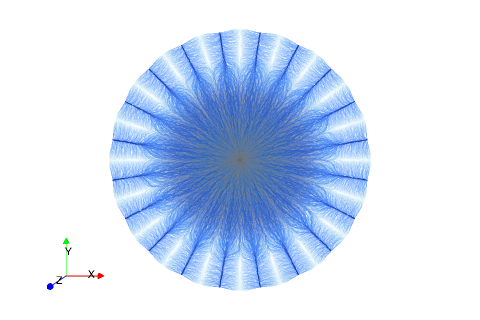

'saved.png'

In [10]:
#Plot a static image with a saved camera setup
#lv.translation(0.00558684254065156, 1.16282057762146, -8.33703231811523)
#lv.rotation(-0.487509340047836, 0.172793388366699, 0.269237726926804, 0.807206630706787)
lv.display(resolution=[480,320])
lv.image('saved.png', resolution=[6000,3000], transparent=True) #Save to disk

In [11]:
#State of properties and view can be loaded and saved to a file
lv.save("state.json")
#lv.file("state.json")
